In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib
matplotlib.rcParams.update({'font.size': 26})
import sys
sys.path.append(r'C:\Users\Rory\extra_repos\ruairitran\package')
from ephys_plots import heatmap_by_cluster

In [2]:
save_dir = r'E:\figures\drug_effects'

In [3]:
def loader(par, exp):
    increase = f'{exp}_increase.csv'
    increase = pd.read_csv(os.path.join(par, increase), index_col=0)
    
    decrease = f'{exp}_decrease.csv'
    decrease = pd.read_csv(os.path.join(par, decrease), index_col=0)
    
    non_responders = f'{exp}_two tailed.csv'
    non_responders = pd.read_csv(os.path.join(par, non_responders), index_col=0)
    
    return increase, decrease, non_responders

In [4]:
d = r'E:\db\drug_effects'
cit_increase, cit_decrease, cit_non_responders = loader(d, 'acute_cit')
sal_increase, sal_decrease, sal_non_responders = loader(d, 'acute_sal')

In [5]:
ci = {col: {'Drug':'Citalopram', 'Response': 'Increase'} for col in cit_increase.columns}
cd = {col: {'Drug':'Citalopram', 'Response': 'Decrease'} for col in cit_decrease.columns}
cn = {col: {'Drug':'Citalopram', 'Response': 'No Response'} for col in cit_non_responders.columns}

cit = {**ci, **cd, **cn}

In [6]:
si = {col: {'Drug':'Saline', 'Response': 'Increase'} for col in sal_increase.columns}
sd = {col: {'Drug':'Saline', 'Response': 'Decrease'} for col in sal_decrease.columns}
sn = {col: {'Drug':'Saline', 'Response': 'No Response'} for col in sal_non_responders.columns}

sal = {**si, **sd, **sn}

In [7]:
both = {**cit, **sal}

In [8]:
exp ='cit'

In [9]:
df = pd.DataFrame(both).transpose()
df.index.name = 'neuron_id'
df = df.reset_index()

In [10]:
c = r'E:\db\CLUSTERS_DONE.csv'

dfc =  pd.read_csv(c)
dfc = dfc[['hc_cluster', 'neuron_id', 'colors']]
dfc['neuron_id'] = dfc['neuron_id'].astype('str')


df = pd.merge(left=df, right=dfc, on='neuron_id', how='left')

In [11]:
clusters = df['hc_cluster'].unique()

In [14]:
df.groupby(['Drug', 'Response'])['neuron_id'].count()

Drug        Response   
Citalopram  Decrease       26
            Increase       25
            No Response    38
Saline      Decrease       22
            Increase        7
            No Response    22
Name: neuron_id, dtype: int64

In [12]:
df_out2 = df.pivot_table(index=['hc_cluster', 'Drug'], columns='Response', aggfunc='count')['neuron_id']
df_out2

Response                           Decrease  Increase  No Response
hc_cluster             Drug                                       
Clocklike Slow Regular Citalopram      10.0       8.0         25.0
                       Saline          15.0       1.0         12.0
Fast Varied            Citalopram       3.0      11.0          5.0
                       Saline           3.0       1.0          5.0
Slow Irregular         Citalopram       9.0       2.0          6.0
                       Saline           4.0       5.0          3.0
Very Fast Regular      Citalopram       4.0       4.0          2.0
                       Saline           NaN       NaN          2.0

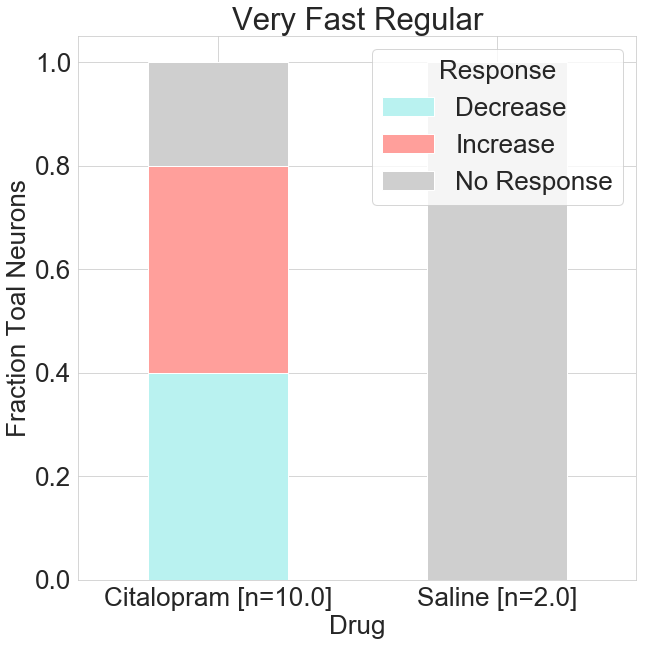

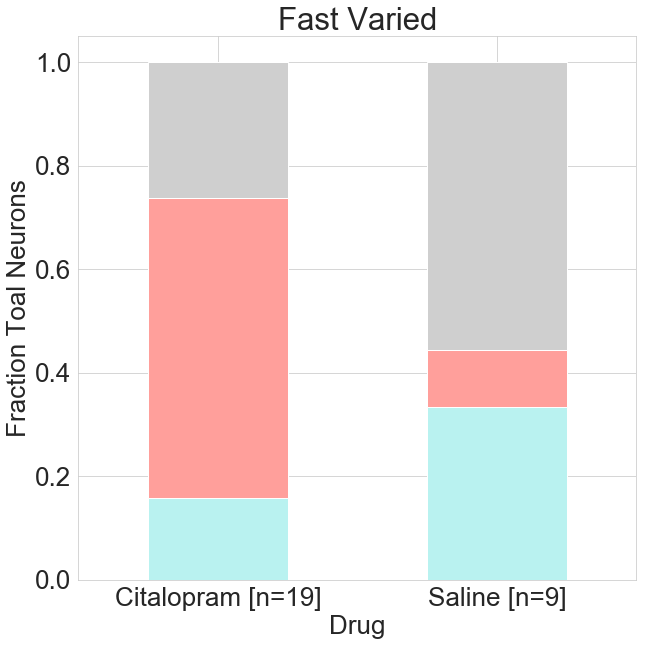

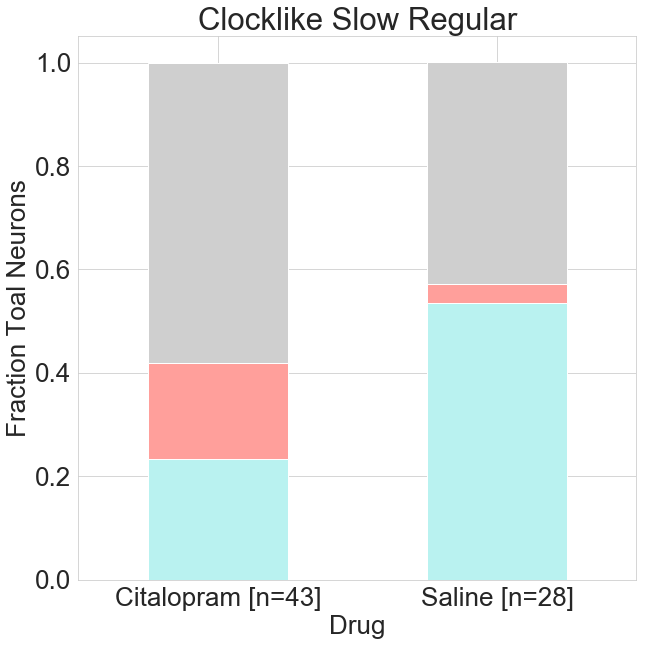

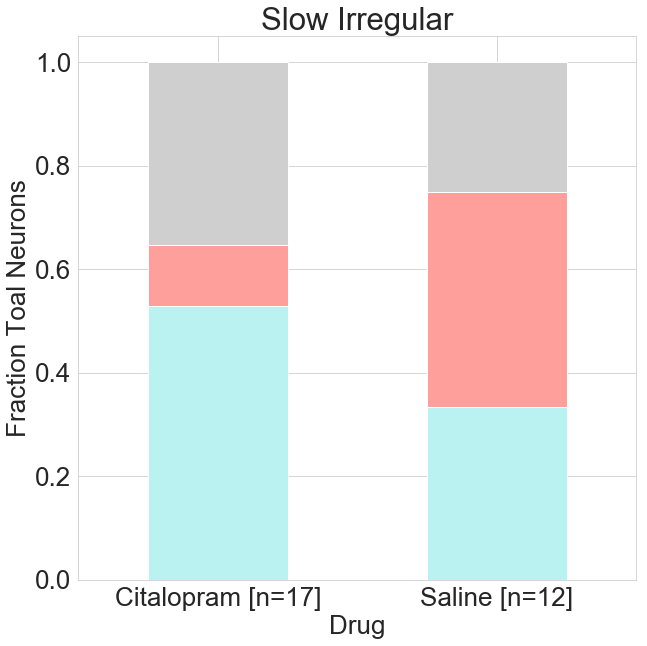

In [44]:
clusters = df['hc_cluster'].unique()
cmap = sns.color_palette('pastel', n_colors=20)[::-6]

save_dir = r'E:\figures\drug_effects'

# for cluster in clusters
for i, cluster in enumerate(clusters):
    f, a = plt.subplots(figsize=(10, 10))
    dfs = df[df['hc_cluster']==cluster]
    dfp = dfs.groupby(['Response', 'Drug']).size().reset_index().pivot(columns='Response',
                                                                index='Drug', values=0).fillna(0)
    sums = dfp.apply(np.sum, axis=1).values
    dfp = dfp.apply(lambda x: np.round(x/np.sum(x), 3), axis=1)
    dfp.reset_index().plot(x='Drug', kind='bar', stacked=True, 
                           color=cmap, ax=a)
    a.set_title(cluster)
    a.set_xticklabels([f'Citalopram [n={sums[0]}]', f'Saline [n={sums[1]}]'])
    plt.xticks(rotation=0)
    if i != 0:
        a.legend_.remove()
    a.set_ylabel('Fraction Toal Neurons')

#     plt.savefig(os.path.join(save_dir, f'{exp}_{cluster}_bar.png'), dpi=300)


In [20]:
dfp.apply(np.sum, axis=1).values[0]

1.0

In [45]:
def gen_subclusters(ts, dfc):
    return dfc.loc[dfc['neuron_id'].isin(ts.columns)]

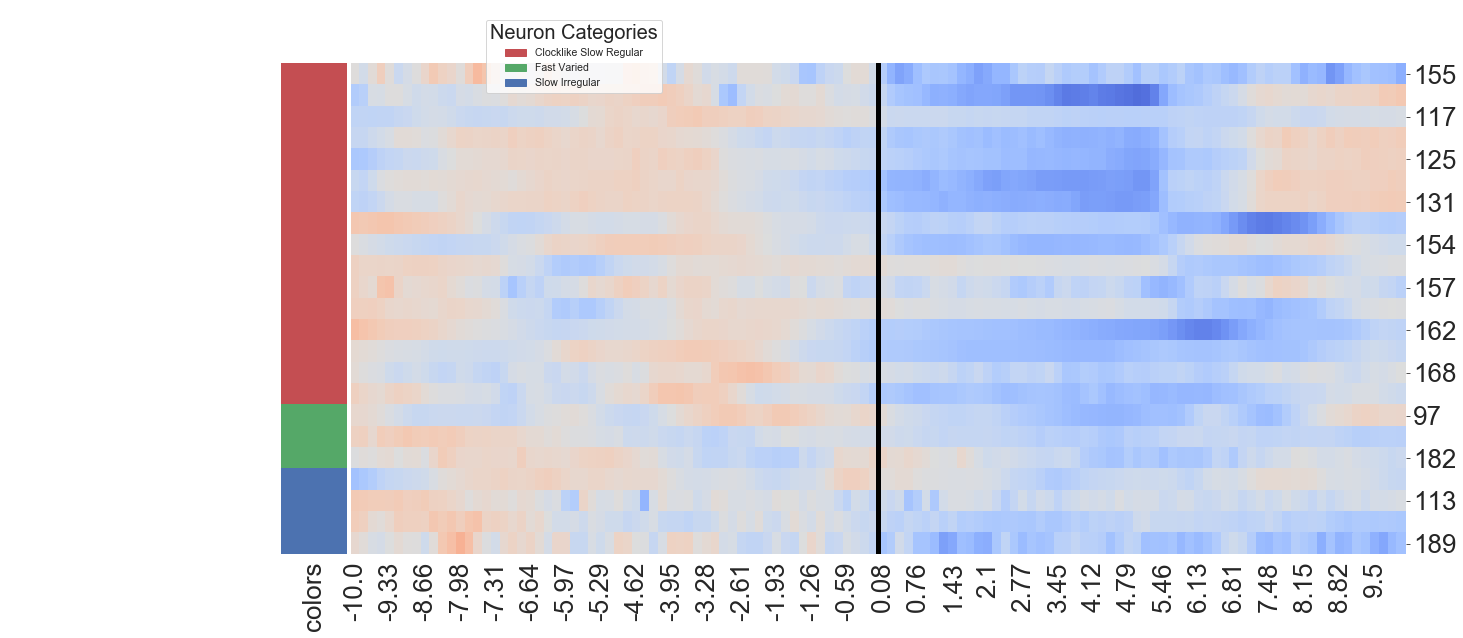

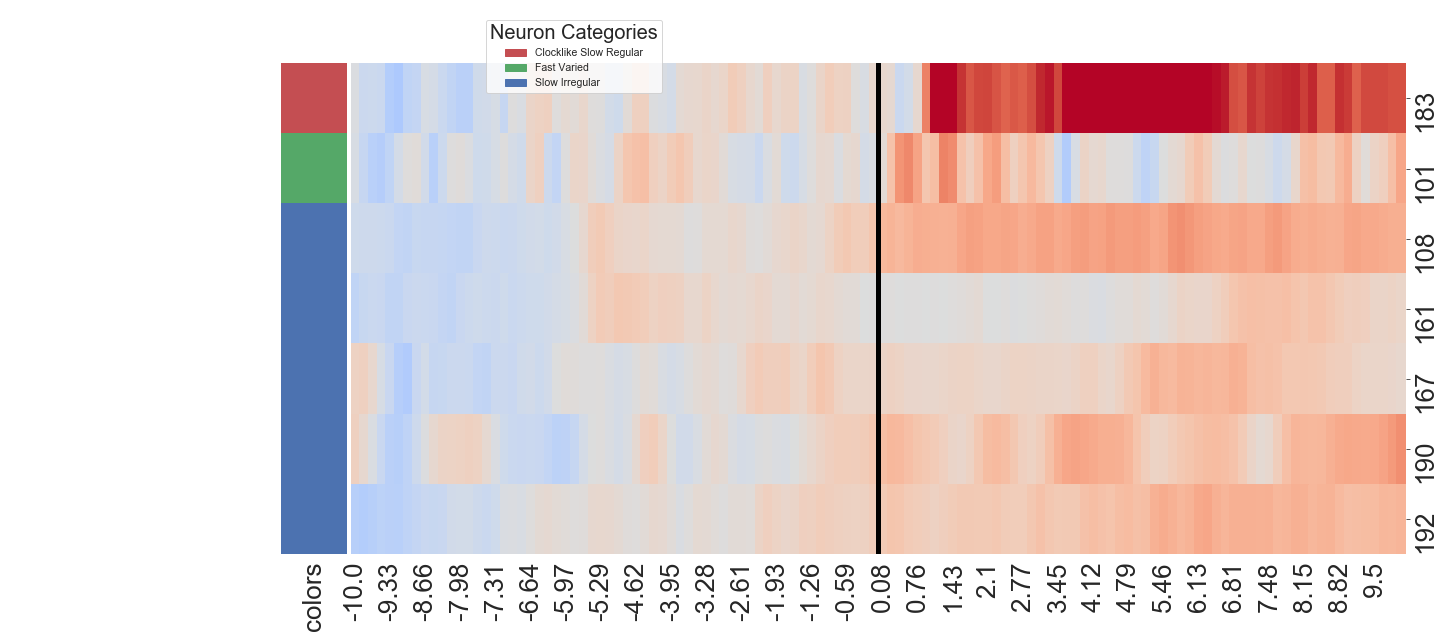

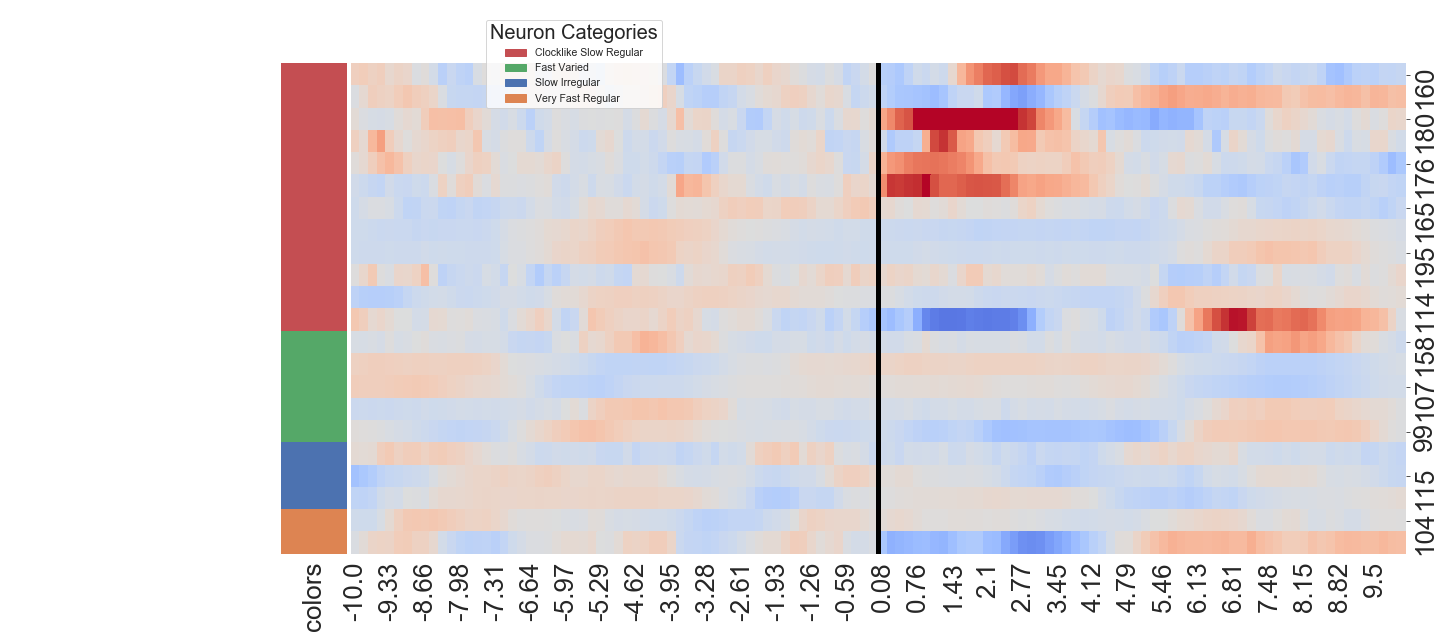

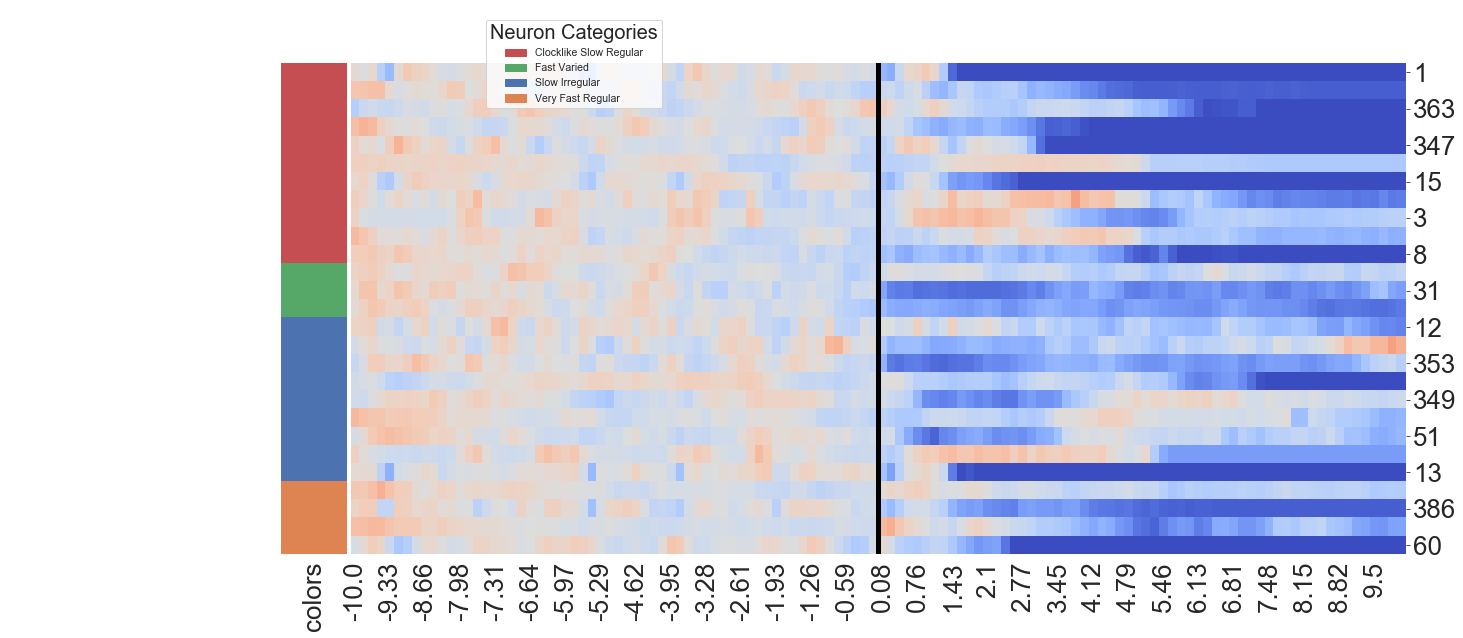

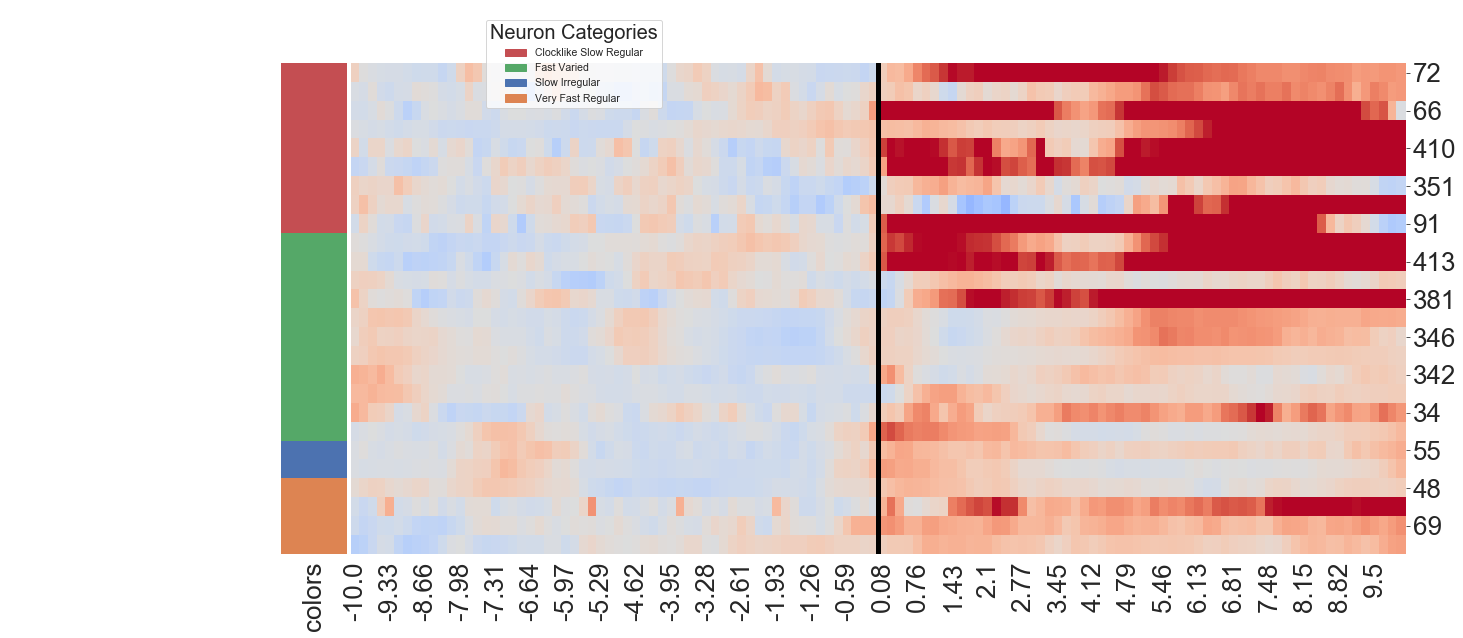

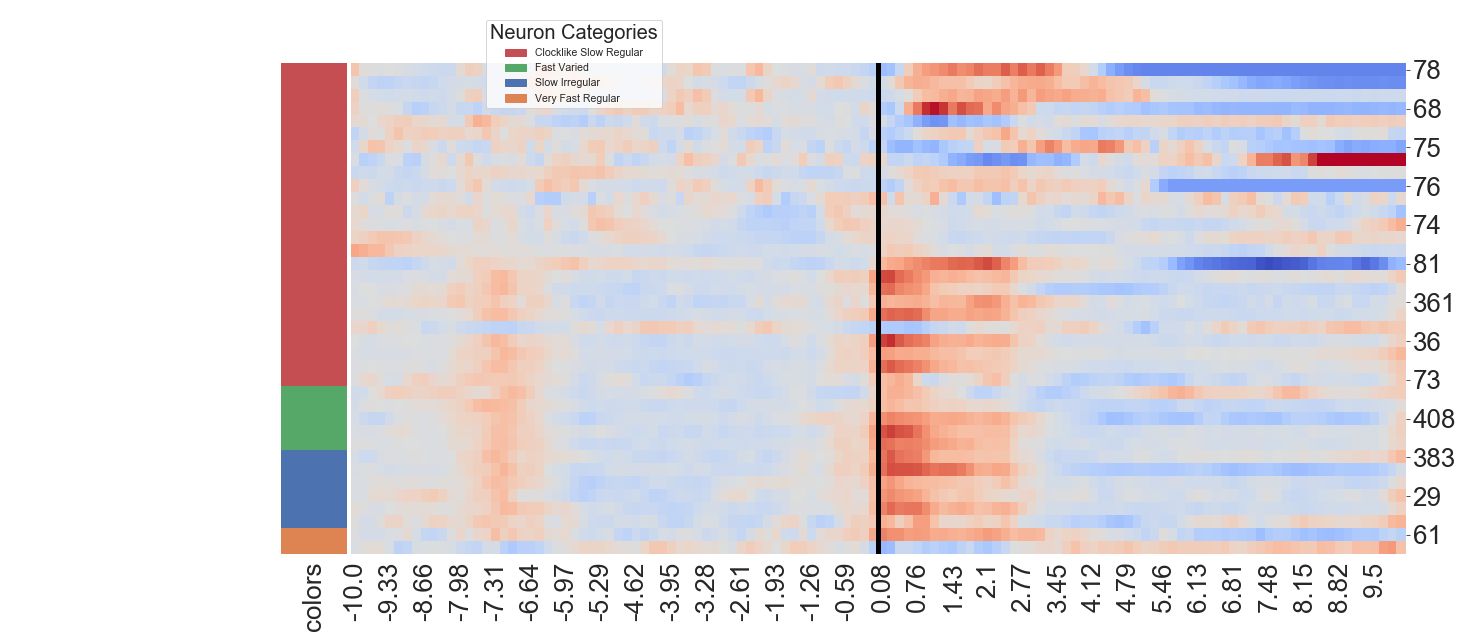

In [46]:
datasets = [('sal_decrease', sal_decrease), ('sal_increase', sal_increase), ('sal_non_responders', sal_non_responders),
          ('cit_decrease', cit_decrease), ('cit_increase', cit_increase), ('cit_non_responders', cit_non_responders)]

count=0
l=True
for name, dataset in datasets:
    if count!= 0:
        l = False
    subc = gen_subclusters(ts=dataset, dfc=dfc)
    cm = heatmap_by_cluster(subc, dataset, cluster_lab ='hc_cluster', vmin=-8, vmax=8, 
                            norm_period=60, spacing=False, label=l)
    cm.cax.set_visible(False)
    plt.savefig(os.path.join(save_dir, f'{exp}_{name}_heat'), dpi=300)